# Ex 13

In [1]:
import numpy as np
import open3d as o3d
import cv2
import matplotlib.pyplot as plt

In [2]:
folder = "casper/"
c = np.load(folder + "calib.npy", allow_pickle=True).item()
c

{'K0': array([[1.09058826e+03, 0.00000000e+00, 4.22000000e+02],
        [0.00000000e+00, 1.09058826e+03, 3.38000000e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 'd0': array([-0.03720395, -0.2353958 ,  0.        ,  0.        ,  0.        ]),
 'K1': array([[1.09454675e+03, 0.00000000e+00, 4.22000000e+02],
        [0.00000000e+00, 1.09454675e+03, 3.38000000e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 'd1': array([-0.04744541, -0.00026868,  0.        ,  0.        ,  0.        ]),
 'R': array([[ 0.91398722, -0.07814026,  0.39814758],
        [ 0.07619891,  0.99687725,  0.02072451],
        [-0.39852369,  0.01139647,  0.91708726]]),
 't': array([[-407.240143 ],
        [  -1.5053668],
        [  85.688652 ]])}

Purpose of images at each index explained
- 0 is an image fully illuminated by the projector (projector showing a white image)
- 1 is an image with the projector fully off
- 2-17 are the 16 images in the primary pattern shifting. This pattern has 40 periods.
- 18-25 are the 8 images of the secondary pattern shifting. This pattern has 41 periods

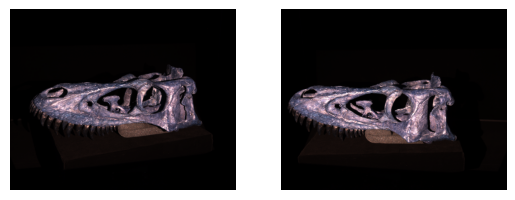

In [3]:
im0 = cv2.imread(folder + "sequence/frames0_0.png")
im1 = cv2.imread(folder + "sequence/frames1_0.png")

# Before rectification
fig, ax = plt.subplots(1, 2)
ax[0].imshow(im0)
ax[0].axis("off")
ax[1].imshow(im1)
ax[1].axis("off")
plt.show()

In [4]:
# Ex 13.2
## Initialize maps for rectification
im0 = cv2.imread(folder + "sequence/frames0_0.png")
size = (im0.shape[1], im0.shape[0])
stereo = cv2.stereoRectify(
    c["K0"], c["d0"], c["K1"], c["d1"], size, c["R"], c["t"], flags=0
)

R0, R1, P0, P1 = stereo[:4]
maps0 = cv2.initUndistortRectifyMap(
    c["K0"], c["d0"], R0, P0, size, cv2.CV_32FC2
)
maps1 = cv2.initUndistortRectifyMap(
    c["K1"], c["d1"], R1, P1, size, cv2.CV_32FC2
)

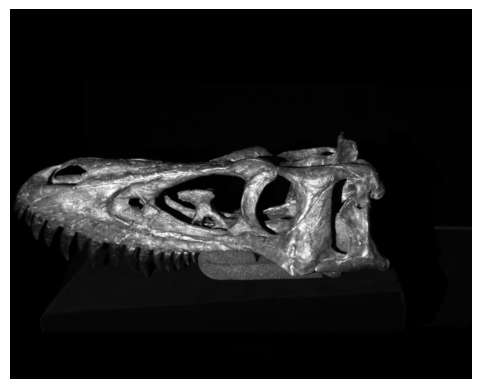

In [5]:
## Do a sample rectification on 1 image
im1 = cv2.imread(folder + "sequence/frames1_0.png").astype(float).mean(2) / 255
b = cv2.remap(im1, *maps1, cv2.INTER_LINEAR)
plt.imshow(b, cmap="gray")
plt.axis("off")
plt.show()

In [6]:
# Rectify all images
n_frames = 26
imgs0_rect = np.zeros((n_frames, size[1], size[0]))
imgs1_rect = np.zeros((n_frames, size[1], size[0]))
for i in range(n_frames):
    # Load and convert to grayscale
    img0 = (
        cv2.imread(folder + "sequence/frames0_%d.png" % i).astype(float).mean(2)
        / 255
    )
    img1 = (
        cv2.imread(folder + "sequence/frames1_%d.png" % i).astype(float).mean(2)
        / 255
    )
    imgs0_rect[i] = cv2.remap(img0, *maps0, cv2.INTER_LINEAR)
    imgs1_rect[i] = cv2.remap(img1, *maps1, cv2.INTER_LINEAR)

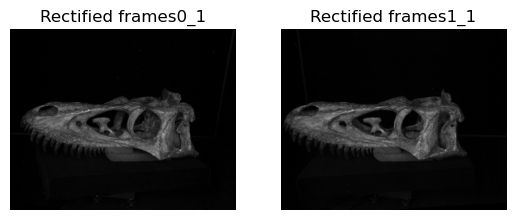

In [7]:
plt.subplot(1, 2, 1)
plt.imshow(imgs0_rect[1], cmap="gray")
plt.title("Rectified frames0_1")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(imgs1_rect[1], cmap="gray")
plt.title("Rectified frames1_1")
plt.axis("off")
plt.show()

In [8]:
# Ex 13.3
def unwrap(imgs, n1):
    """
    Unwrap the measured phases. Adapter from Collister.

    Args:
        imgs (List[np.ndarray]): List of images from the cameras.
        n1 (int): Period of the primary pattern.

    Returns:
        theta_est (np.ndarray) : The phase of the primary pattern.
    """
    # Primary pattern
    primary_images = imgs[2:18]  # 16 images
    fft_primary = np.fft.rfft(primary_images, axis=0)
    fourier_primary = fft_primary[1]
    theta_primary = np.angle(fourier_primary)

    # Secondary pattern
    secondary_images = imgs[18:26]
    fft_secondary = np.fft.rfft(secondary_images, axis=0)
    fourier_secondary = fft_secondary[1]
    theta_secondary = np.angle(fourier_secondary)

    # Compute phase cue using heterodyne principle
    theta_c = np.mod(theta_secondary - theta_primary, 2 * np.pi)

    # Order of primary phase
    o_primary = np.rint((n1 * theta_c - theta_primary) / (2 * np.pi))

    # Estimate the phase
    theta_est = np.mod((2 * np.pi * o_primary + theta_primary) / n1, 2 * np.pi)
    return theta_est

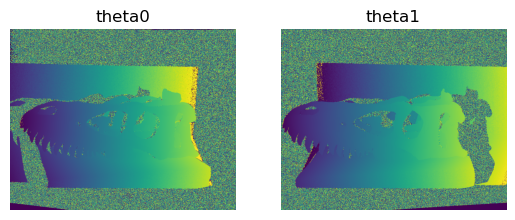

In [9]:
theta0 = unwrap(imgs0_rect, 40)
theta1 = unwrap(imgs1_rect, 40)

plt.subplot(1, 2, 1)
plt.imshow(theta0)
plt.title("theta0")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(theta1)
plt.title("theta1")
plt.axis("off")
plt.show()

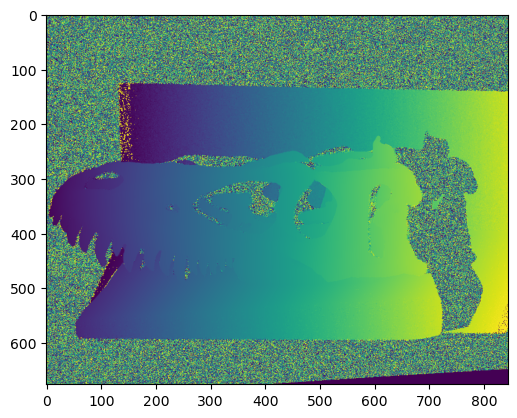

In [14]:
plt.imshow(theta1)

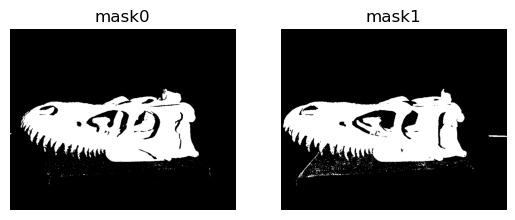

In [10]:
# Ex 13.4
# Introduce binary mask that contains areas sufficiently illuminated
light0 = imgs0_rect[0] - imgs0_rect[1]  # fully on - full off
light1 = imgs1_rect[0] - imgs1_rect[1]

# Divide threshold by 255 as the pixels are normalised [0,1]
threshold = 15 / 255

# Apply a threshold to obtain a mask for EACH CAMERA
mask0 = (light0 > threshold).astype(np.uint8)
mask1 = (light1 > threshold).astype(np.uint8)

plt.subplot(1, 2, 1)
plt.imshow(mask0, cmap="gray")
plt.title("mask0")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(mask1, cmap="gray")
plt.title("mask1")
plt.axis("off")
plt.show()

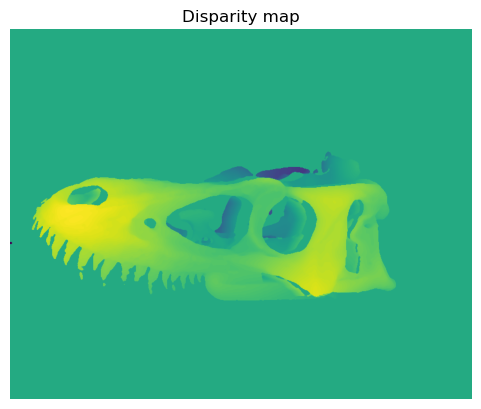

In [11]:
# Ex 13.5
# Find matches between the 2 cameras
shape = mask0.shape
shape1 = mask1.shape
q0s = []
q1s = []
disparity = np.zeros_like(mask0, dtype=np.float32)  # Initialize with zeros

# Iterate over all pixels in camera 0
for i0 in range(shape[0]):
    point0 = (0, 0)
    point1 = (0, 0)
    for j0 in range(shape[1]):
        minDiff = 1000000
        if mask0[i0, j0]:  # valid pixel
            phase = theta0[i0][j0]
            epipolar_row = theta1[i0]  # row i0 in camera 1
            valid_epipolar_row = epipolar_row * mask1[i0]

            # closest phase match
            j1 = (np.abs(valid_epipolar_row - phase)).argmin()
            q0s.append([j0, i0])
            q1s.append([j1, i0])
            disparity[i0][j0] = j0 - j1

plt.imshow(cv2.medianBlur(disparity.astype(np.float32), 5))
plt.title("Disparity map")
plt.axis("off")
plt.show()

In [12]:
# Ex 13.6
# Triangulate the 3D points
projPoints0 = np.array(q0s).T.astype(np.float32)
projPoints1 = np.array(q1s).T.astype(np.float32)

Q = cv2.triangulatePoints(
    projMatr1=P0, projMatr2=P1, projPoints1=projPoints0, projPoints2=projPoints1
)
Q = Q[:-1] / Q[-1]  # convert to non-homogenous

# Remove negative z-coordinates that are behind the camera
Q_mask = np.where(Q[2] > 0, True, False)
Q_fixed = (Q.T[Q_mask]).T

# Visualize 3D point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(Q_fixed.T)
o3d.visualization.draw_geometries([pcd])

Screenshots from the Open3D window

<img src="media/open3d_plot1.png" height="300">
<img src="media/open3d_plot2.png" height="300">

In [13]:
# For exam Q21
disparity[360, 400]

np.float32(-21.0)